In [14]:
import scanpy as sc
import pandas as pd
import numpy as np
import warnings
from copy import copy
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

from rpy2.robjects import r

import rpy2.rinterface_lib.callbacks
import anndata2ri
from sklearn.preprocessing import minmax_scale

anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Get all d16 cells and d25 and d50_d70 tanycytes, integrate with FastMNN

In [2]:
adata_d16 = sc.read('Data/adata_d16_annotated.h5ad')
adata_d25 = sc.read('Data/adata_d25_annotated.h5ad')
adata_d50_d70 = sc.read('Data/adata_d50_d70_annotated.h5ad')

In [3]:
adata_d16.obs['reactionID'] = 'd16'
adata_d25 = adata_d25[adata_d25.obs['Cell_types'].isin(['Tanycytes'])]
adata_d50_d70 = adata_d50_d70[adata_d50_d70.obs['Cell_types'].isin(['Tanycytes'])]

del adata_d16.var
del adata_d25.var
del adata_d50_d70.var

adata = adata_d50_d70.concatenate(adata_d16,adata_d25, batch_key=None, join='outer')

adata.obs.dimensionality = adata.obs.dimensionality.fillna('2D')

del adata.obsm

sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='reactionID')
hvg = adata.var[adata.var['highly_variable'] == True].index.to_list()

adata

AnnData object with n_obs × n_vars = 18854 × 32644
    obs: 'sampleID', 'reactionID', 'diff_batch', 'diff_batch_2', 'dimensionality', 'day', 'condition', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_HTO', 'nFeature_HTO', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'integrated_snn_res.0.1', 'Cell_types', 'Cell_types_2', 'leiden', 'integrated_snn_res.0.85', 'integrated_snn_res.1', 'integrated_snn_res.1.2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log_transformed', 'ambiguous', 'spliced', 'unspliced'

In [4]:
%%R -i adata -i hvg -o fastmnn_embed

Csparse_validate = "CsparseMatrix_validate"
library(Seurat)
library(batchelor)

sobj <- as.Seurat(adata, counts = "counts", data = "log_transformed")

sobj <- subset(sobj, features=hvg)
print(sobj)
expr <- GetAssayData(sobj, slot = "data")

sce <- fastMNN(expr, batch = sobj@meta.data[['reactionID']])

sobj@reductions['fastmnn'] <- CreateDimReducObject(reducedDim(sce, "corrected"), key = 'fastmnn_')

fastmnn_embed = Embeddings(object = sobj, reduction = "fastmnn")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    An object of class Seurat 
2000 features across 18854 samples within 1 assay 
Active assay: originalexp (2000 features, 0 variable features)


Attaching SeuratObject

Attaching package: ‘Seurat’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays

In addition: Warning messages:
1: In .refine_k(k, precomputed, query = TRUE) :
  'k' capped at the number of observations
2: In .refine_k(k, precomputed, query = TRUE) :
  'k' capped at the number of observations
3: In `[<-`(`*tmp*`, "fastmnn", value = list(fastmnn = new("DimReduc",  :
  implicit list embedding of S4 objects is deprecated


In [5]:
adata.obsm['fastmnn'] = fastmnn_embed
sc.pp.neighbors(adata, use_rep="fastmnn",n_neighbors=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

In [7]:
adata.write('Data/tanycyte_pseudotime.h5ad')

# Monocle3 analysis

In [15]:
adata = sc.read('Data/tanycyte_pseudotime.h5ad')
hvg = adata.var[adata.var['highly_variable'] == True].index.to_list()
len(hvg)

2000

In [5]:
%%R -i adata -i hvg

library(Seurat)
library(monocle3)

sobj <- as.Seurat(adata, counts = "counts", data = "log_transformed")
sobj_subset = subset(sobj, features = hvg)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Attaching SeuratObject

Attaching package: ‘Seurat’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays


Attaching package: ‘monocle3’

The following objects are masked from ‘package:Biobase’:

    exprs, fData, fData<-, pData, pData<-



In [6]:
%%R
AssociatedDimReducs <- function(
  object,
  assay = DefaultAssay(object = object),
  global = TRUE
) {
  return(Filter(
    f = function(x) {
      check <- DefaultAssay(object = object[[x]]) == assay
      if (global) {
        check <- c(check, IsGlobal(object = object[[x]]))
      }
      return(any(check))
    },
    x = Reductions(object = object)
  ))
}


convert_to_cds <- function(
  x,
  assay = DefaultAssay(object = x),
  reductions = AssociatedDimReducs(object = x, assay = assay),
  default.reduction = DefaultDimReduc(object = x, assay = assay),
  graph = paste0(assay, '_snn'),
  group.by = NULL,
  ...
) {
  clusters.key <- 'monocle3_clusters' 
  partitions.key <- 'monocle3_partitions'
  # Add assay data
  # Cheat and use as.SingleCellExperiment
  cds <- as(
    object = as.SingleCellExperiment(x = x, assay = assay),
    Class = 'cell_data_set'
  )
  # Ensure we have a counts assay
  if (is.null(x = SummarizedExperiment::assays(x = cds)$counts)) {
    SummarizedExperiment::assays(x = cds)$counts <- SummarizedExperiment::assays(x = cds)[[1]]
  }
  # Add Size_factor
  if (!"Size_Factor" %in% colnames(x = SummarizedExperiment::colData(x = cds))) {
    size.factor <- paste0('nCount_', assay)
    if (size.factor %in% colnames(x = x[[]])) {
      SummarizedExperiment::colData(x = cds)$Size_Factor <- x[[size.factor, drop = TRUE]]
    }
  }
  # Add DimReducs: Embeddings become a reduced dim, Loadings go to
  # reduce_dim_aux$gene_loadings, Stdev goes go reduce_dim_aux$prop_var_expl
  # First, reset the ones from as.SingleCellExperiment
  SingleCellExperiment::reducedDims(x = cds)[SingleCellExperiment::reducedDimNames(x = cds)] <- NULL
  reductions <- intersect(
    x = reductions,
    y = AssociatedDimReducs(object = x, assay = assay)
  )
  for (reduc in reductions) {
    SingleCellExperiment::reducedDims(x = cds)[[toupper(x = reduc)]] <- Embeddings(object = x[[reduc]])
    loadings <- Loadings(object = x[[reduc]])
    if (!IsMatrixEmpty(x = loadings)) {
      slot(object = cds, name = 'reduce_dim_aux')[['gene_loadings']] <- loadings
    }
    stdev <- Stdev(object = x[[reduc]])
    if (length(x = stdev)) {
      slot(object = cds, name = 'reduce_dim_aux')[['prop_var_expl']] <- stdev
    }
  }
  # Add clustering information
  # TODO: Figure out if I need to add relations, distMatrix, or clusters/partitions
  if (!is.null(x = group.by)) {
    Idents(object = x) <- group.by
  }
  # if (clusters.key %in% colnames(x = x[[]])) {
  clusters.list <- if (is.null(x = group.by) && all(c(clusters.key, partitions.key) %in% colnames(x = x[[]]))) {
    message("Using existing Monocle 3 cluster membership and partitions")
    list(
      partitions = factor(x = x[[partitions.key, drop = TRUE]]),
      clusters = factor(x = x[[clusters.key, drop = TRUE]])
    )
  } else if (graph %in% names(x = x)) {
    g <- igraph::graph_from_adjacency_matrix(
      adjmatrix = x[[graph]],
      weighted = TRUE
    )
    # TODO: figure out proper partitioning scheme
    # partitions <- igraph::components(graph = g)$membership[colnames(x = x)]
    warning(
      "Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object",
      call. = FALSE,
      immediate. = TRUE
    )
    partitions <- rep_len(x = 1, length.out = ncol(x = x))
    list(
      cluster_result = list(
        g = g,
        relations = NULL,
        distMatrix = 'matrix',
        coord = NULL,
        edge_links = NULL,
        optim_res = list(
          membership = as.integer(x = Idents(object = x)),
          modularity = NA_real_
        )
      ),
      partitions = factor(x = partitions),
      clusters = Idents(object = x)
    )
  } else {
    list()
  }
  if (length(x = clusters.list)) {
    slot(object = cds, name = 'clusters')[[toupper(x = default.reduction)]] <- clusters.list
  }
  # TODO: Add translated results from learn_graph
  return(cds)
}

cds = convert_to_cds(sobj_subset)

In [29]:
%%R
cds <- cluster_cells(cds, resolution=0.00007)

cds <- learn_graph(cds, use_partition = FALSE) #graph learned across all partitions
umap = plot_cells(cds, show_trajectory_graph = TRUE,
           label_principal_points = TRUE,label_branch_points=FALSE)
png('monocle3_plots/umap_final.png', res=280, width=1550, height=1300)
print(umap)

  |======================================================================| 100%


In [30]:
%%R
cds <- order_cells(cds,root_pr_nodes='Y_76')
umap = plot_cells(cds, color_cells_by = "pseudotime", label_branch_points=F, label_leaves=FALSE)
png('monocle3_plots/umap_pseudotime_final.png', res=350, width=1300, height=1000)
print(umap)

Cells aren't colored in a way that allows them to be grouped.


In [ ]:
%%R
cds_tany <- choose_graph_segments(cds,starting_pr_node='Y_76', ending_pr_nodes = c('Y_116','Y_103','Y_91','Y_92','Y_2','Y_16','Y_84','Y_96','Y_128','Y_112'),clear_cds=F)
cds_neurons <- choose_graph_segments(cds,starting_pr_node='Y_76', ending_pr_nodes = c('Y_27','Y_48','Y_55'),clear_cds=F)

saveRDS(cds_tany,'monocle_cds_tany.RDS')
saveRDS(cds_neurons,'monocle_cds_neurons.RDS')
saveRDS(cds,'monocle_cds_all.RDS')

In [6]:
%%R -o pseudotime_values_tany -o pseudotime_values_neurons -o pseudotime_values_all -o tany_lineage_cells -o neurons_lineage_cells
library(monocle3)
cds_tany = readRDS('monocle_cds_tany.RDS')
cds_neurons = readRDS('monocle_cds_neurons.RDS')
cds = readRDS('monocle_cds_all.RDS')

tany_lineage_cells = colnames(cds_tany)
neurons_lineage_cells = colnames(cds_neurons)
#all_cells = colnames(cds_tany)


pseudotime_values_tany = pseudotime(cds_tany, reduction_method = "UMAP")
pseudotime_values_neurons = pseudotime(cds_neurons, reduction_method = "UMAP")
pseudotime_values_all = pseudotime(cds, reduction_method = "UMAP")



Loading required package: Biobase
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required

In [7]:
adata_tanycyte_lineage = adata[tany_lineage_cells]
adata_neurons_lineage = adata[neurons_lineage_cells]

# Temporal gene expression analysis over the identified tanycyte lineage

In [22]:
adata_tany = adata[tany_lineage_cells]
adata_neurons = adata[neurons_lineage_cells]

adata_tany.obs['monocle3_pseudotime'] = pseudotime_values_tany
adata_neurons.obs['monocle3_pseudotime'] = pseudotime_values_neurons


    
gene_list = ['RAX', 'HIGD2A', 'SOX2', 'PTTG1', 'CCNB1', 'NOSTRIN', 'RORB', 'SPRY1', 'INPP4B', 'NFIB', 'COL25A1', 'GFPT1', 'MATR3-1', 'SLC3A2', 
             'PTGDS', 'HTR2C', 'NFIA', 'NRP1', 'DIO2', 'PIP5K1B', 'CPNE8', 'CRYM']

# Function that fits gene expression with pseudotime
def assign_polyfit(adata):
    df=pd.DataFrame(adata[:,gene_list].copy().X.toarray(),columns=gene_list)
    df['pseudotime']=adata.obs['monocle3_pseudotime'].values
    
    df=df.sort_values(by='pseudotime',ascending=True)
    df_fit=df
    for i,gene in enumerate(gene_list):

        fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=6)
        f = np.poly1d(fit)
        df_fit[gene]=f(df['pseudotime'])
        
        rowix=df_fit.T.idxmax(axis=1)
        pseudo=pd.DataFrame(df_fit['pseudotime'][rowix].values,index=df_fit.columns[0:df_fit.shape[1]])
        pseudo=pseudo.sort_values(by=0,ascending=True)
        df_fit=df_fit[pseudo.index]

    
    return df_fit
    
    
# Call polynomial fit function
df_fit_tany = assign_polyfit(adata_tany)
df_fit_neurons = assign_polyfit(adata_neurons)  
neurons_column_order = list(df_fit_neurons.columns[:-2])


#df_fit_neurons.iloc[:,:-1] = minmax_scale(df_fit_neurons.iloc[:,:-1], axis=0)

# Concat gene X cell dataframes
df_fit_tany['source'] = 'tanycytes'
df_fit_neurons['source'] = 'neurons'


df_concat = pd.concat([df_fit_tany,df_fit_neurons ])

# Scale merged dataframe
df_concat.iloc[:,:-2] = minmax_scale(df_concat.iloc[:,:-2], axis=0)

# Split gene X cell dataframe 
df_fit_tany=df_concat[df_concat.source.isin(['tanycytes'])]
df_fit_neurons=df_concat[df_concat.source.isin(['neurons'])]
df_fit_neurons = df_fit_neurons[neurons_column_order]

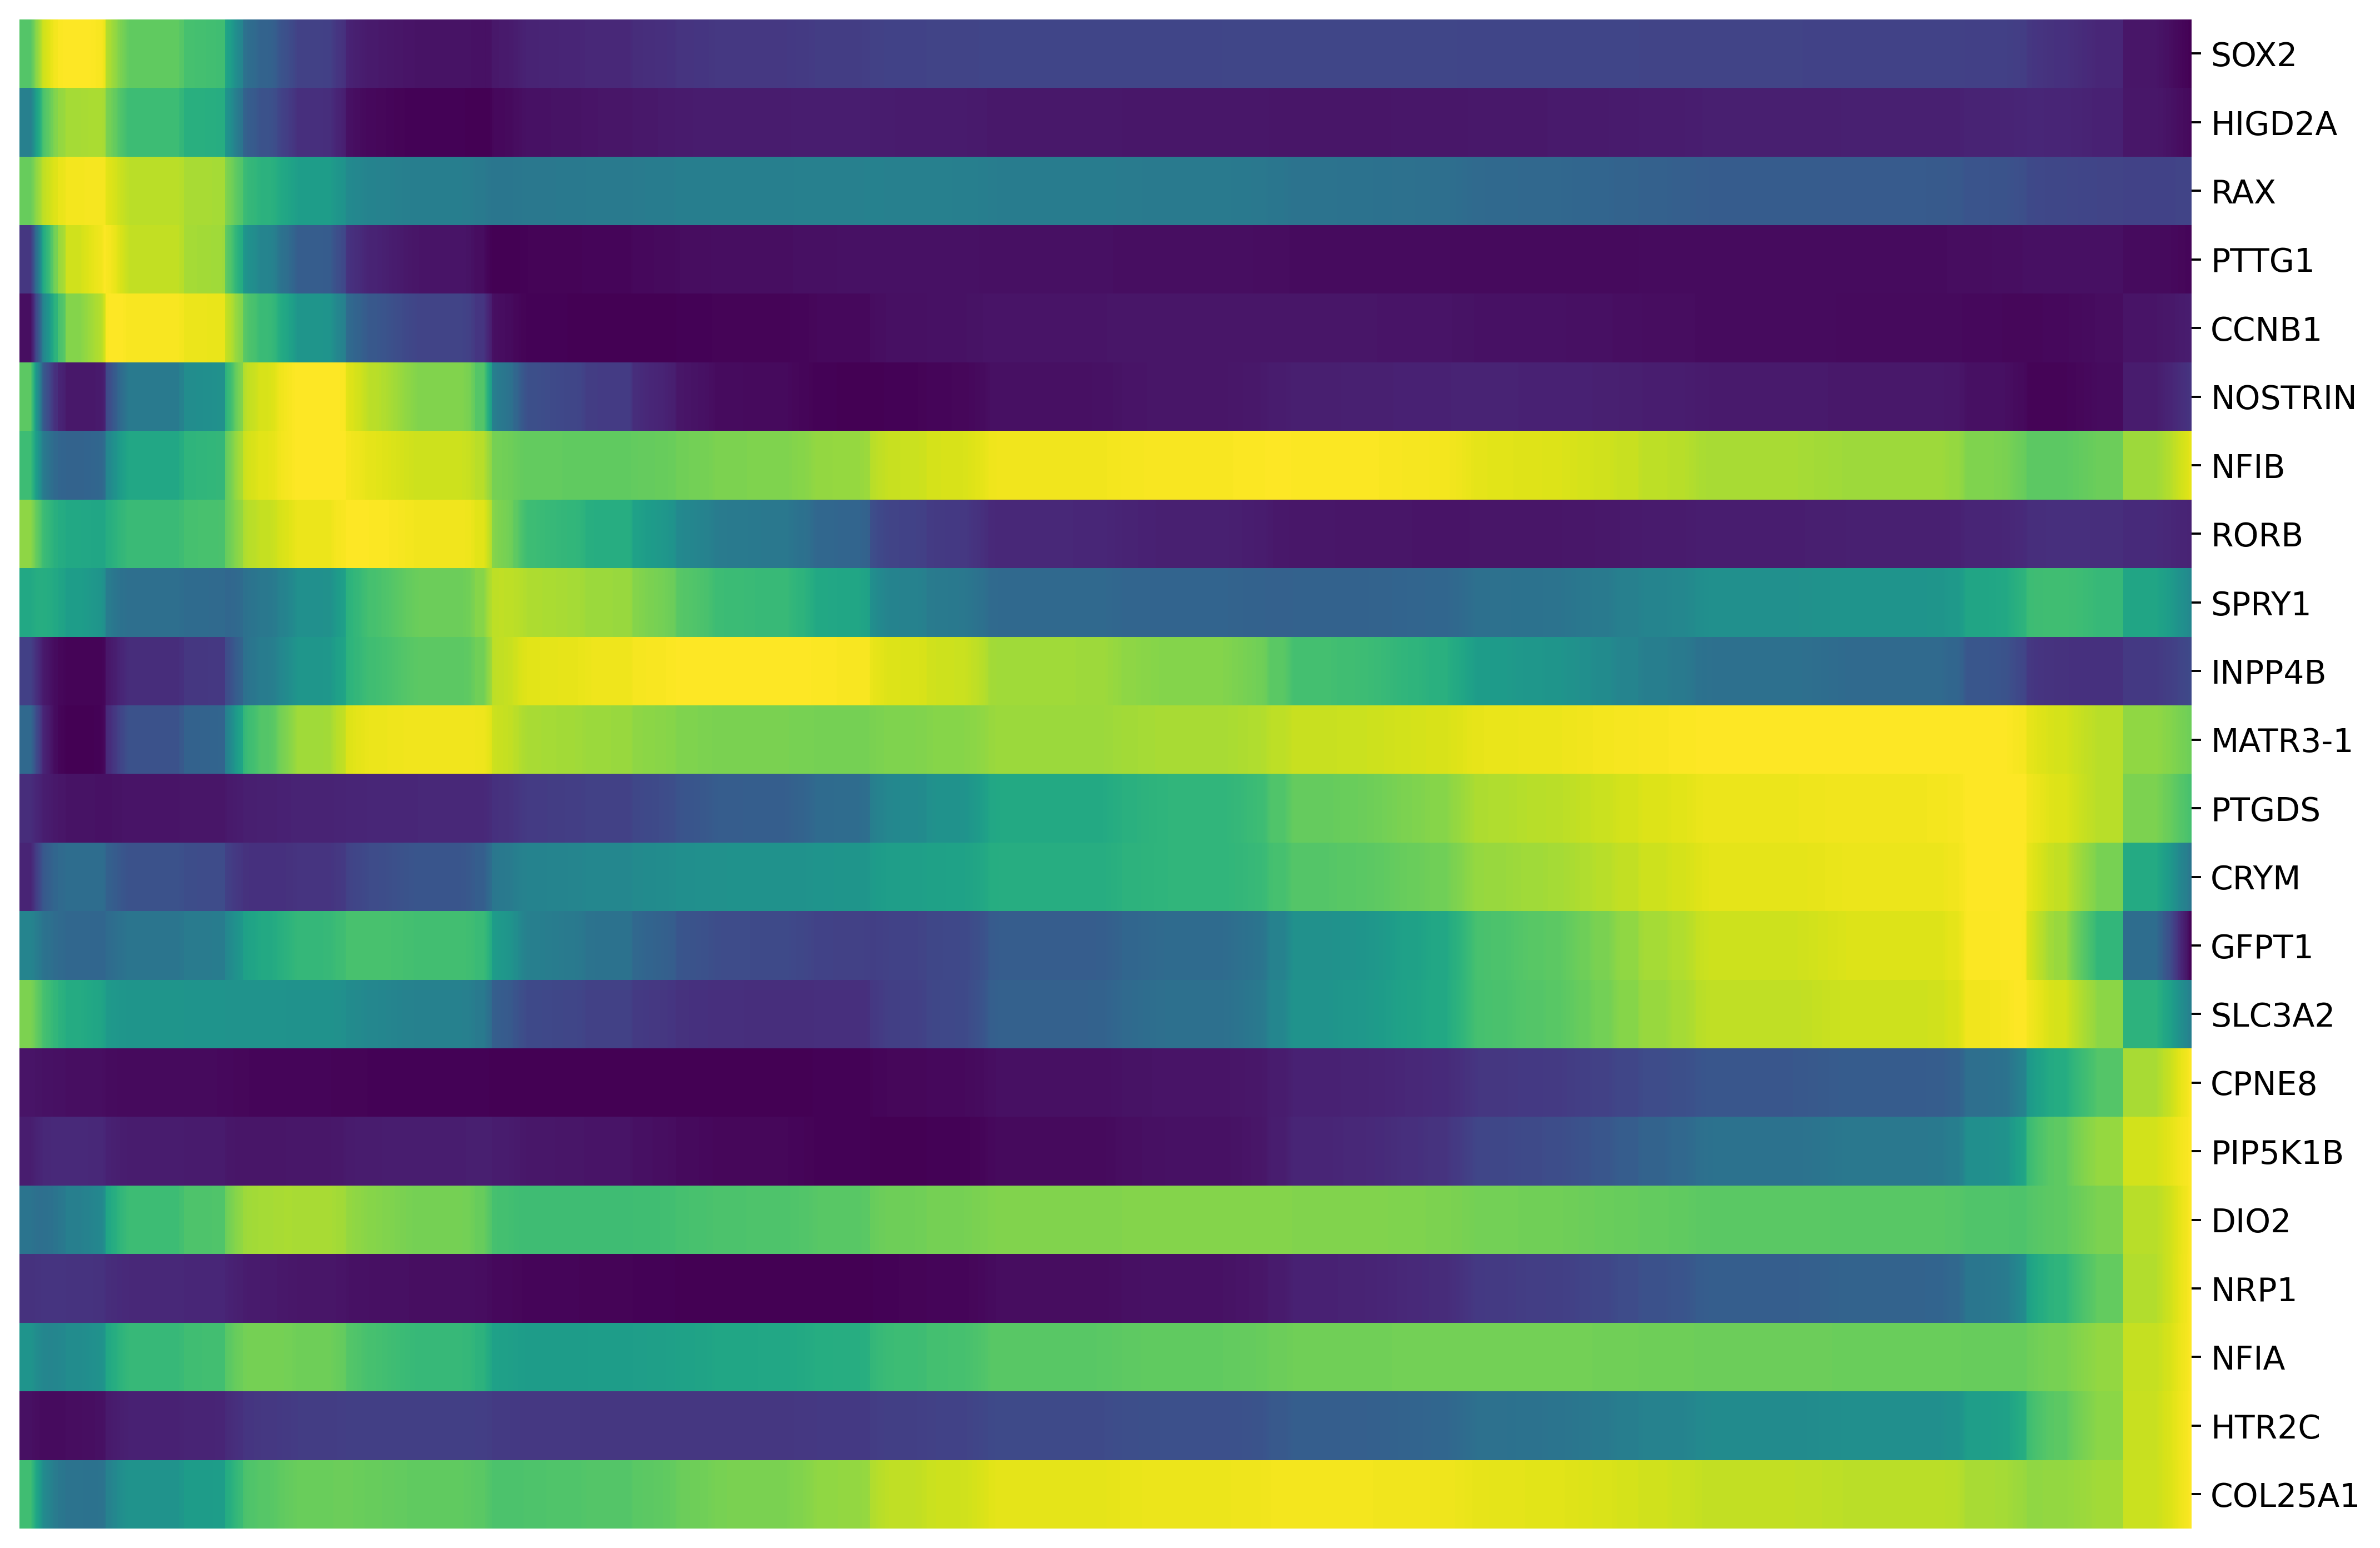

In [160]:
#sns.set_palette(sns.color_palette(colors))

with plt.rc_context({ "figure.dpi": 350}):
    cm = sns.clustermap(df_fit_tany.iloc[:,:-2].T,col_cluster=False,row_cluster=False,standard_scale=None, 
                        figsize=(15,10),xticklabels=False, cmap='viridis')
    cm.cax.set_visible(False)
    cm.ax_row_dendrogram.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    cm.tick_params(labelsize=12)
    plt.show()
    cm.savefig('monocle3_plots/tanycytes_temporal_gene_expression.pdf')


# Plotting umaps

In [112]:

from pandas.api.types import CategoricalDtype
adata.obs.day = adata.obs.day.replace('d16','D16')
cat_type = CategoricalDtype(categories=['D16', 'D25', 'D50', 'D70'], ordered=True)

adata.obs.day = adata.obs.day.astype(cat_type)

In [16]:
for color in ['COL25A1']:
    with plt.rc_context({ "figure.dpi": 300 }):
        sc.pl.umap(adata, color=color, ncols=2, use_raw=False, cmap='jet', frameon=False, colorbar_loc=None,size=18, save=f'tanycytes_{color}.pdf', show=False,layer='log_transformed')
        #sc.pl.umap(adata, color=color, ncols=2, use_raw=False, cmap='jet', frameon=False, colorbar_loc=None,size=18)

In [23]:
adata_d16.obs.Cell_types = adata_d16.obs.Cell_types.astype(str)
adata.obs.Cell_types = adata.obs.Cell_types.astype(str)


cells = pd.Series(list(adata[adata.obs.day.isin(['d16'])].obs.index), dtype="category")
adata.obs["Cell_types"].loc[cells] = list(adata_d16.obs.Cell_types.values)


In [31]:
adata.obs['monocle3_pseudotime'] = pseudotime_values_all
neuron_series = pd.Series(list(adata[adata.obs_names.isin(neurons_lineage_cells)].obs.index), dtype="category")
adata.obs["monocle3_pseudotime"].loc[neuron_series] = -1.0

In [36]:
%%R -i adata

sobj <- as.Seurat(adata, counts = "counts", data = "log_transformed")

In [85]:
%%R
library(ggplot2)
#FeaturePlot(object = sobj,  order = TRUE, features='monocle3_pseudotime',cmap)
umap = FeaturePlot_scCustom(seurat_object = sobj, features = "monocle3_pseudotime",colors_use=viridis_plasma_light_high) + labs(title = "Tanycyte lineage")

png('monocle3_plots/umap_tany_lineage.png', res=170, width=1000, height=1000)
print(umap)

In addition: Warning message:
Some of the plotted features are from meta.data slot.
• Please check that `na_cutoff` param is being set appropriately for those
  features. 
